## BONDS

In [ ]:
import datetime
import re

In [ ]:
!pip install quandl

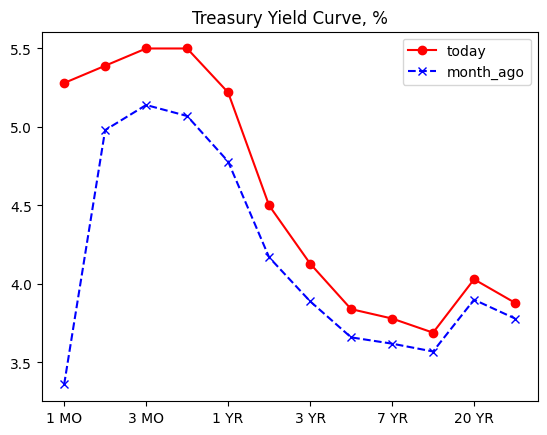

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import quandl as ql
#import Quandl as ql
%matplotlib inline

yield_ = ql.get("USTREASURY/YIELD")
today = yield_.iloc[-1,:]
month_ago = yield_.iloc[-30,:]
df = pd.concat([today, month_ago], axis=1)
df.columns = ['today', 'month_ago']

df.plot(style={'today': 'ro-', 'month_ago': 'bx--'}
        ,title='Treasury Yield Curve, %');

In [ ]:
import datetime
from scipy.optimize import newton

def calculate_yield_to_maturity(face_value, coupon_rate, payment_frequency, years_to_maturity, bond_price):
    def price_function(yield_to_maturity):
        coupon_payment = (coupon_rate / payment_frequency) * face_value
        total_payments = payment_frequency * years_to_maturity
        discount_factor = sum([(1 + yield_to_maturity / payment_frequency) ** (-n) for n in range(1, total_payments + 1)])
        price = (coupon_payment * (1 - (1 + yield_to_maturity / payment_frequency) ** (-total_payments))) / (yield_to_maturity / payment_frequency) + (face_value / (1 + yield_to_maturity / payment_frequency) ** total_payments)
        return price

    yield_to_maturity = newton(lambda y: price_function(y) - bond_price, 0.05)

    return yield_to_maturity

def calculate_accrued_interest(issue_date, coupon_rate, payment_frequency, purchase_date=None, sale_date=None):
    today = datetime.date.today()

    if purchase_date is None:
        purchase_date = today

    if sale_date is None:
        sale_date = today

    days_since_last_payment = (purchase_date - issue_date).days % payment_frequency
    days_in_current_payment_term = (sale_date - purchase_date).days

    accrued_interest = (coupon_rate / payment_frequency) * days_since_last_payment

    if days_in_current_payment_term > 0:
        accrued_interest += (coupon_rate / payment_frequency) * days_in_current_payment_term

    return accrued_interest

def calculate_bond_price(face_value, coupon_rate, yield_to_maturity, payment_frequency, years_to_maturity):
    coupon_payment = (coupon_rate / payment_frequency) * face_value
    total_payments = payment_frequency * years_to_maturity
    discount_factor = sum([(1 + yield_to_maturity / payment_frequency) ** (-n) for n in range(1, total_payments + 1)])
    price = (coupon_payment * (1 - (1 + yield_to_maturity / payment_frequency) ** (-total_payments))) / (yield_to_maturity / payment_frequency) + (face_value / (1 + yield_to_maturity / payment_frequency) ** total_payments)
    return price

issue_date = datetime.date(2021, 1, 1)
face_value = 1000
coupon_rate = 0.05
yield_to_maturity = 0.06
payment_frequency = 2  # Semi-annual payments
years_to_maturity = 5
purchase_date = datetime.date(2023, 3, 15)
sale_date = datetime.date(2023, 8, 30)

accrued_interest = calculate_accrued_interest(issue_date, coupon_rate, payment_frequency, purchase_date, sale_date)
bond_price = calculate_bond_price(face_value, coupon_rate, yield_to_maturity, payment_frequency, years_to_maturity)

print("Accrued Interest:", accrued_interest)
print("Bond Price:", bond_price)


Accrued Interest: 4.2250000000000005
Bond Price: 957.3489858161208


In [ ]:
# newton raphson method for roots 
# def pv_num_derivative(r):
#     return (self.pv(r+0.001)-self.pv(r))/0.001

# def ytm(price):
#     x = 0
#     while(abs(round(self.pv(x)-price,2))>0):
#         x = x - (self.pv(x)-price)/self.pv_num_derivative(x)
#         # print(x)
#     return x 

# SOFR INDEX

In [ ]:
import pandas as pd
df = pd.read_csv('SOFR.csv')

In [ ]:
len(df)

1305

In [ ]:
df.replace(".", pd.NA, inplace=True)

# Drop rows where 'SOFR' column is equal to NaN
df.dropna(subset=['SOFR'], inplace=True)

# Reset the index if desired
df.reset_index(drop=True, inplace=True)

In [ ]:
def calculate_sofr_index(sofr_values):
    sofr_index = [1]  # Initialize the SOFR index list with an initial value of 1

    for i in range(1, len(sofr_values)):
        dt = sofr_values[i-1] / 100
        dx = 1 / 360
        compounded_value = sofr_index[i-1] * (1 + dt * dx)
        sofr_index.append(compounded_value)

    return sofr_index

In [ ]:
sofr = df.SOFR
sofr_float = [float(i) for i in sofr]

In [ ]:
sofr_index = calculate_sofr_index(sofr_float)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(df.DATE,sofr_index)

# YIELD CURVES

Suppose we have 'N' traded fixed income securities. 

Maturities of these securities = T<sub>1</sub>,T<sub>2</sub>,.......T<sub>N</sub>,

From their market prices, we are able to compute their yields as - y(T<sub>i</sub>
)

To extend the yield curve from finite tenors to a range [T<sub>1</sub>,T<sub>n</sub>] we can carry out some interpolation procedure


Spot Curves = LIBOR curve, Government rate curve, etc

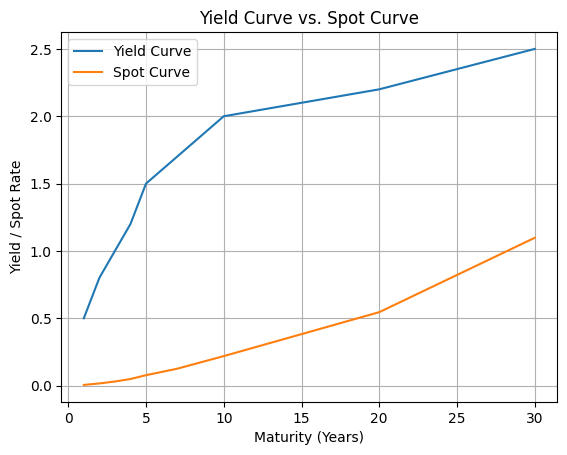

In [ ]:
# Example data for yield curve
maturities = [1, 2, 3, 4, 5, 7, 10, 20, 30]
yields = [0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2, 2.5]

def calculate_spot_rates(yields, maturities):
    spot_rates = []

    for i in range(len(yields)):
        spot_rate = (1 + yields[i] / 100) ** maturities[i] - 1
        spot_rates.append(spot_rate)

    return spot_rates

spot_rates = calculate_spot_rates(yields, maturities)
# Create DataFrame
data = pd.DataFrame({'Maturities': maturities, 'Yields': yields, 'Spot Rates': spot_rates})

# Plotting
plt.plot(data['Maturities'], data['Yields'], label='Yield Curve')
plt.plot(data['Maturities'], data['Spot Rates'], label='Spot Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield / Spot Rate')
plt.title('Yield Curve vs. Spot Curve')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


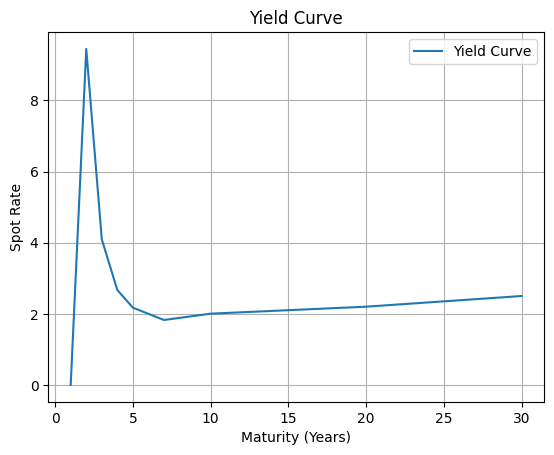

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def spot_rate_equation(y, coupon_payments, face_value, cash_flows, spot_rates):
    present_value = np.sum(coupon_payments / (1 + y) ** cash_flows) + face_value / (1 + y) ** cash_flows[-1] - 1
    return present_value

def bootstrap_yield_curve(maturities, bond_prices, coupon_payments, face_value):
    spot_rates = [0]  # Start with a spot rate of 0 for the first maturity

    for i in range(1, len(maturities)):
        cash_flows = np.arange(1, maturities[i] + 1)
        y = fsolve(spot_rate_equation, 0.05, args=(coupon_payments[i], face_value, cash_flows, spot_rates[-1]))
        spot_rates.append(y[0])

    return spot_rates

# Example data
maturities = [1, 2, 3, 4, 5, 7, 10, 20, 30]
bond_prices = [98.5, 97.8, 95.2, 92.6, 90.1, 85.6, 80.2, 70.5, 60.2]
coupon_payments = [0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2, 2.5]
face_value = 100

# Bootstrap yield curve
spot_rates = bootstrap_yield_curve(maturities, bond_prices, coupon_payments, face_value)

# Plotting yield curve
plt.plot(maturities, spot_rates, label='Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate')
plt.title('Yield Curve')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


# Nelson-Siegel-Svensson: Estimating the Spot Rate Curve


*The Nelson-Siegel-Svensson (1994) model is used to “fill in the gaps” of missing spot yields and term structure of interest rates whereby the model can be used to both interpolate missing data points within a time series of interest rates (as well as other macroeconomic variables such as inflation rates and commodity prices or market returns) and also used to extrapolate outside of the given or known range, useful for forecasting purposes.*


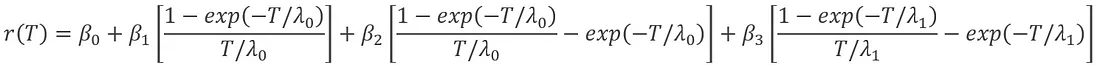


Where β0, β1, β2, β3, λ0 and λ1 are the constant parameters and T is the time to maturity in annual units.


In [46]:
import numpy as np
import pandas as pd
m = [1,2,3,4,5,8,10,15,20,25,30]
y = [0.39,0.61,np.nan,np.nan,1.66,np.nan,2.58,np.nan,np.nan,3.32,np.nan]


In [53]:
import numpy as np
from scipy.optimize import minimize

def nss_curve(maturities, params):
    beta0, beta1, beta2, tau1, tau2 = params
    return beta0 + beta1 * ((1 - np.exp(-maturities / tau1)) / (maturities / tau1)) + beta2 * (((1 - np.exp(-maturities / tau2)) / (maturities / tau2)) - np.exp(-maturities / tau2))

def objective_function(params, maturities, yields):
    predicted_yields = nss_curve(maturities, params)
    return np.sum((yields - predicted_yields) ** 2)

# Example data
maturities = np.array([1, 2, 3, 4, 5, 7, 10, 20, 30])
yields = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05])

# Initial guess for the model parameters
p0 = (0.01, 0.01, 0.01, 1, 1)

# Parameter optimization
result = minimize(objective_function, p0, args=(maturities, yields))
params = result.x

# Generate the estimated yield curve
estimated_yields = nss_curve(maturities, params)

# Print the estimated parameters
print("NSS model parameters:")
print("Beta0:", params[0])
print("Beta1:", params[1])
print("Beta2:", params[2])
print("Tau1:", params[3])
print("Tau2:", params[4])


NSS model parameters:
Beta0: 0.052862946129100606
Beta1: -0.04407303412440688
Beta2: -0.06385366691211301
Tau1: 1.002572824378741
Tau2: 1.2976499520293379
